# Multiprocessing on GPU on scisoft16

In this tutorial, the idea is to parallelized the reading of several HDF5 files in different processes and to perform the azimuthal integration on the GPU together with the Bitshuffle-LZ decompression.

The size of the problem is 1000 files containing 1000 frames each of 4Mpix. That's one million frames. Reduced data are 1000x1000x1000 in single precision float.

This is an extreme case where we will try how to use all resources of the computer, so the first thing to do is to determine the topology of the computer:
* Levovo computer with AMD Epyc processors (Generation Genoa).
* 1 processors, 8x4 cores. 4 cores share one L3-cache on 32MB
* 1 Nvidia Tesla L40s GPUs (Generation Dad-lovelace).

**Disclaimer:**
* We use `multiprocess` instead of the `multiprocessing` library to be able to demonstrate the precedure with the jupuyter notebook.
* We use `SharedArray` to provide a natural way of sharing the result array in memory between processes.

Those python packages must be installed to be able to run the notebook

Failed to open /tmp/topo.png for writing (File exists)


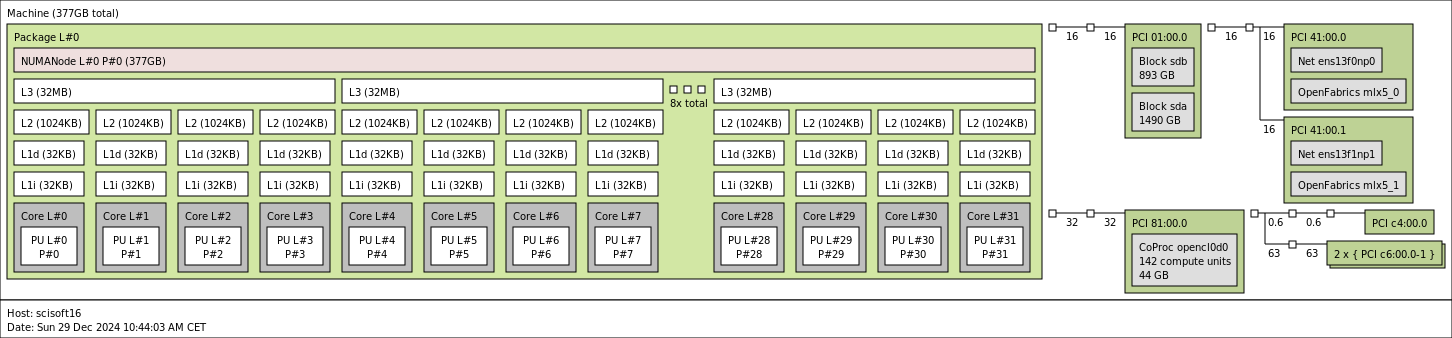

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

#Topology of the computer:
!lstopo /tmp/topo.png
from IPython.display import Image
Image(filename='/tmp/topo.png') 

In [2]:
import os
import glob
import concurrent
import time
import json
from matplotlib.pyplot import subplots
import multiprocess
from multiprocess import Process, Value, Array
if "mpctx" in globals():
    mpctx = multiprocess.get_context('spawn')
else:
    multiprocess.set_start_method('spawn')
    mpctx = multiprocess.get_context('spawn')
import numpy
import hdf5plugin
import h5py
import pyFAI
print("pyFAI version: ", pyFAI.version)
import SharedArray
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
import inspect
import collections
Item = collections.namedtuple("Item", "index filename")
MAIN_PROCESS = multiprocess.parent_process() is None
print(ocl)

pyFAI version:  2025.1.0-dev0
OpenCL devices:
[0] NVIDIA CUDA: (0,0) NVIDIA L40S


In [3]:
#This cell contains the parameters for all the processing
params = {
    "DEVICES": [[0,0],],
    "NWORKERS": 32,
    "FRAME_PER_FILE": 1000,
    "NFILES" : 1000,
    "NBINS" : 1000,
    "DETECTOR":"Eiger_4M",
    "pathname" : "/scratch/kieffer/big_%04d.h5",
    "pathmask" : "/scratch/kieffer/big_????.h5",
    "dtype" : "float32",
    "SHARED_NAME" : "shm://multigpu",
    "array_shape" : [1000, 1000, 1000],
    }
with open("param.json", "w") as w: w.write(json.dumps(params, indent=2))
for k,v in params.items():
    globals()[k] = v

In [4]:
def build_integrator(detector=DETECTOR):
    "Build an azimuthal integrator with a dummy geometry"
    geo = {"detector": detector, 
           "wavelength": 1e-10, 
           "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
    ai = pyFAI.load(geo)
    return ai

In [5]:
# Generate a set of files
def generate_one_frame(ai, unit="q_nm^-1", dtype="uint32"):
    """Prepare a frame with little count so that it compresses well"""
    qmax = ai.array_from_unit(unit=unit).max()
    q = numpy.linspace(0, qmax, 100)
    img = ai.calcfrom1d(q, 100/(1+q*q))
    frame = numpy.random.poisson(img).astype(dtype)
    return frame

def generate_files(img):
    cmp = hdf5plugin.Bitshuffle()
    filename = pathname%0
    shape = img.shape
    with h5py.File(filename, "w") as h:
        ds = h.create_dataset("data", shape=(FRAME_PER_FILE,)+shape, chunks=(1,)+shape, dtype=img.dtype, **cmp) 
        for i in range(FRAME_PER_FILE):
            ds[i] = img + i%500 #Each frame has a different value to prevent caching effects
    res = [filename]
    for i in range(1, NFILES):
        new_file = pathname%i
        os.link(filename,new_file)
        res.append(new_file)
    return res

# Create a set of files with dummy data in them:
if len(glob.glob(pathmask)) == NFILES: 
    input_files = glob.glob(pathmask)
    input_files.sort()
else:
    for f in glob.glob(pathmask):
        os.remove(f)
    input_files = generate_files(generate_one_frame(build_integrator(DETECTOR)))
input_files[:5]

['/scratch/kieffer/big_0000.h5',
 '/scratch/kieffer/big_0001.h5',
 '/scratch/kieffer/big_0002.h5',
 '/scratch/kieffer/big_0003.h5',
 '/scratch/kieffer/big_0004.h5']

In [6]:
#This is allows to create and destroy shared numpy arrays

def create_shared_array(shape, dtype="float32", name=SHARED_NAME, create=False):
    if create:
        ary = SharedArray.create(name, shape, dtype=dtype)
    else:
        ary = SharedArray.attach(name)
    return ary

def release_shared(name=SHARED_NAME):
    if MAIN_PROCESS:
        SharedArray.delete(name)

result_array = create_shared_array(array_shape, dtype, SHARED_NAME, create=True)

In [7]:
def worker(rank, queue, shm_name, counter):
    """Function representing one worker, used in a pool of worker.
    
    :param rank: integer, index of the worker.
    :param queue: input queue, expects Item with index and name of the file to process
    :param shm_name: name of the output shared memory to put integrated intensities
    :param counter: decremented when quits
    :return: nothing, used in a process.
    """
    def new_engine(engine, wg):
        "Change workgroup size of an engine"
        return engine.__class__((engine._data, engine._indices, engine._indptr), 
                              engine.size, empty=engine.empty, unit=engine.unit, 
                              bin_centers=engine.bin_centers, azim_centers = engine.azim_centers,  
                              ctx=engine.ctx, block_size=wg)
    #imports:
    import pyFAI
    import numpy
    import SharedArray
    from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
    import h5py
    import json
    import sys
    #load parameters:
    for k,v in json.load(open("param.json")).items():
        globals()[k] = v
    #Start up the integrator:
    ai = pyFAI.load({"detector": DETECTOR, 
                     "wavelength": 1e-10, 
                     "rot3":0})
    blank = numpy.zeros(ai.detector.shape, dtype="uint32")
    method = ("full", "csr", "opencl", DEVICES[rank%len(DEVICES)])
    res = ai.integrate1d(blank, NBINS, method=method)
    omega = ai.solidAngleArray()
    engine = ai.engines[res.method].engine
    
    omega_crc = engine.on_device["solidangle"]
    engine = new_engine(engine, 512)
   
    gpu_decompressor = BitshuffleLz4(2000000, blank.size, dtype=blank.dtype, ctx=engine.ctx)
    gpu_decompressor.block_size = 128
    result_array = SharedArray.attach(SHARED_NAME)
    with counter.get_lock():
        counter.value += 1
    #Worker is ready !
    while True:
        item = queue.get()
        index = item.index
        if index<0: 
            with counter.get_lock():
                counter.value -= 1
            return
        with h5py.File(item.filename, "r") as h5:
            ds = h5["data"]
            for i in range(ds.id.get_num_chunks()):
                filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
                if filter_mask == 0:
                    # print(f"{rank}: process frame #{i}")
                    dec = gpu_decompressor(chunk)
                    intensity = engine.integrate_ng(dec, solidangle=omega, solidangle_checksum=omega_crc).intensity
                    result_array[index, i,:] = intensity.astype(dtype)

In [8]:
def build_pool(nbprocess, queue, shm_name, counter):
    """Build a pool of processes with workers, and starts them"""
    pool = []
    for i in range(nbprocess):
        process = Process(target=worker, name=f"worker_{i:02d}", args=(i, queue, shm_name, counter))
        process.start()
        pool.append(process)
    while counter.value<nbprocess:
        time.sleep(1)
    return pool

def end_pool(pool, queue):
    """Ends all processes from a pool by sending them a "kill-pill"""
    for process in pool:
        queue.put(Item(-1, None))

# Build the pool of workers
queue = mpctx.Queue()
counter = mpctx.Value("i", 0)
pool = build_pool(NWORKERS, queue, SHARED_NAME, counter)
pool

Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
Please upgrade to silx v2.2+
/nobackup/

[<Process name='worker_00' pid=3992353 parent=3992198 started>,
 <Process name='worker_01' pid=3992354 parent=3992198 started>,
 <Process name='worker_02' pid=3992355 parent=3992198 started>,
 <Process name='worker_03' pid=3992356 parent=3992198 started>,
 <Process name='worker_04' pid=3992357 parent=3992198 started>,
 <Process name='worker_05' pid=3992358 parent=3992198 started>,
 <Process name='worker_06' pid=3992359 parent=3992198 started>,
 <Process name='worker_07' pid=3992360 parent=3992198 started>,
 <Process name='worker_08' pid=3992361 parent=3992198 started>,
 <Process name='worker_09' pid=3992362 parent=3992198 started>,
 <Process name='worker_10' pid=3992363 parent=3992198 started>,
 <Process name='worker_11' pid=3992364 parent=3992198 started>,
 <Process name='worker_12' pid=3992365 parent=3992198 started>,
 <Process name='worker_13' pid=3992366 parent=3992198 started>,
 <Process name='worker_14' pid=3992367 parent=3992198 started>,
 <Process name='worker_15' pid=3992368 p

In [9]:
start_time = time.perf_counter()
for idx, fn in enumerate(input_files):        
    queue.put(Item(idx, fn))
end_pool(pool, queue)
counter.value

32

In [ ]:
while counter.value:
    time.sleep(1)
run_time = time.perf_counter()-start_time
print(f"run-time: {run_time:.1f}s")

In [ ]:
# result_array

In [ ]:
fig, ax = subplots()
ax.imshow(result_array[:,:,5])

In [ ]:
print(f"Performances: {NFILES*FRAME_PER_FILE/run_time:.3f} fps")

In [ ]:
release_shared(SHARED_NAME)

## Conclusion
It is possible to reach 845 frames per second on a single GPU computer. In this configuration, a million of Eiger4M frames are reduced in something close to 19mn.

Energy considerations for the reduction of one million frames:
* the GPU was consuming 150 W (over the 350W TDP of one GPU) over 1183s which represents 178 kJ (49.2 Wh) for the data reduction.
* The equivalent processing using only a 6-core workstation takes half a day (40682 s) and consumes 1561 kJ (433 Wh).
* Processing on GPUs is thus close to 9x more efficient than processing on CPU only.

Other considerations:
* Here reading from disk is fast enough, no need to put more than 2 processes per GPU. If reading is much slower, more can be beneficial.
* Since the output array is in shared memory, one needs to have enough RAM for hosting it.